# Joint data analysis

This will be the notebook in which I will conduct my joint data analysis.
The idea is that I can use my JOD data as well as my quantitative data from the cluster in order to formulate some joint statements about my model performance.

In [1]:
import pandas as pd

df_jod = pd.read_excel("data/jod.xlsx")
df_metrics = pd.read_excel("data/singleMetricResultClean.xlsx")

## Objective Ranking

### What is the objective ranking per facet of the data?

In [24]:
df_constrained = df_metrics[df_metrics["dataset"] == "room"]
df_constrained

,Unnamed: 0.1,Unnamed: 0,model,dataset,size,view_idx,psnr,ssim,lpips,brisque,brisque_0,brisque_1,brisque_2,brisque_3,brisque_4
672,672,672,default,room,low,0,27.980096,0.824120,0.180635,117.019144,116.521470,116.107287,116.238904,116.105137,116.114672
673,673,673,default,room,low,1,29.939811,0.843994,0.191566,117.417314,116.122930,116.747664,116.796568,116.973098,116.511440
674,674,674,default,room,low,2,29.444911,0.829717,0.213949,117.199998,116.079892,116.392559,117.049091,116.084060,116.217721
675,675,675,default,room,low,3,30.390954,0.880122,0.138366,116.914592,116.066502,116.761068,116.757326,116.119149,116.488936
676,676,676,default,room,low,4,29.759665,0.923680,0.092707,116.711365,116.688301,116.061293,116.858357,117.174938,116.864454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1486,1486,1486,mip-splatting,room,high,34,24.932528,0.943576,0.094137,116.123349,116.095509,116.818257,116.093376,116.190999,116.084207
1487,1487,1487,mip-splatting,room,high,35,28.638101,0.954097,0.069504,116.257823,116.091897,116.397809,116.363249,116.740986,117.706848
1488,1488,1488,mip-splatting,room,high,36,22.231574,0.870438,0.194638,116.643551,116.232880,116.146390,116.094577,116.618809,116.126603
1489,1489,1489,mip-splatting,room,high,37,33.946979,0.945775,0.066577,116.476981,116.745707,116.101132,117.348396,116.046778,116.453808


In [200]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np


def contrast_ranking_by_size(dataset: str) -> None:
    fig, axs = plt.subplots(1, 4, figsize=(24, 6))
    handles, labels = [], []

    for i, metric in enumerate(["psnr", "ssim", "lpips", "brisque"]):
        df_constrained = df_metrics[df_metrics["dataset"] == dataset]
        for model in df_constrained["model"].unique():
            if metric == "brisque":
                sub_df = (
                    (
                        df_constrained[df_constrained["model"] == model][
                            [
                                "size",
                                "brisque",
                                "brisque_0",
                                "brisque_1",
                                "brisque_2",
                                "brisque_3",
                                "brisque_4",
                            ]
                        ]
                        .melt(id_vars="size")
                        .rename({"value": "brisque"}, axis=1)
                    )
                    .groupby(["size"], sort=False, as_index=False)[["brisque"]]
                    .agg(["mean", "std", "count"])
                )
            else:
                sub_df = (
                    df_constrained[df_constrained["model"] == model]
                    .groupby(["size"], sort=False, as_index=False)[[metric]]
                    .agg(["mean", "std", "count"])
                )

            y_vals = sub_df[metric, "mean"]
            ci_1 = sub_df[metric, "std"] / np.sqrt(sub_df[metric, "count"]) * 1

            current_handles = axs[i].plot(["low", "medium", "high"], y_vals)

            if i == 0:
                handles.extend(current_handles)
                labels.append(model)

            axs[i].fill_between(
                ["low", "medium", "high"],
                y_vals - ci_1,
                y_vals + ci_1,
                alpha=0.6,
                color="#d6d6d6",
            )
            axs[i].set_ylabel(metric)

    fig.legend(handles, labels, loc="center left", bbox_to_anchor=(1.0, 0.5))
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.suptitle(f"{dataset} dataset metrics")
    plt.show()

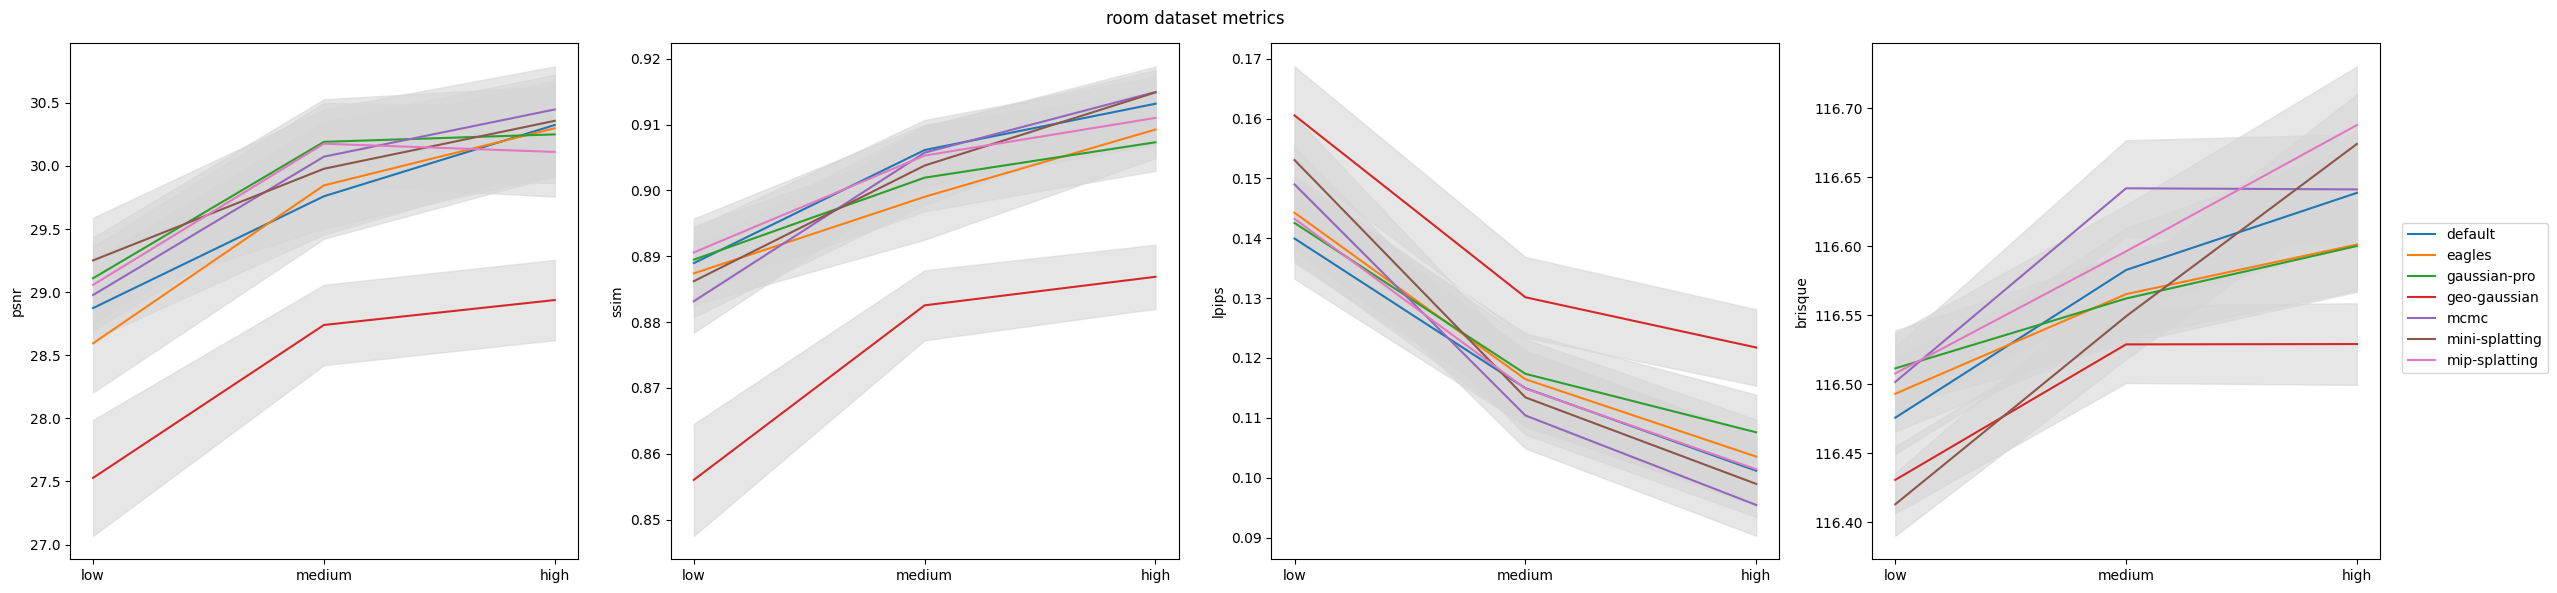

In [201]:
contrast_ranking_by_size("room")

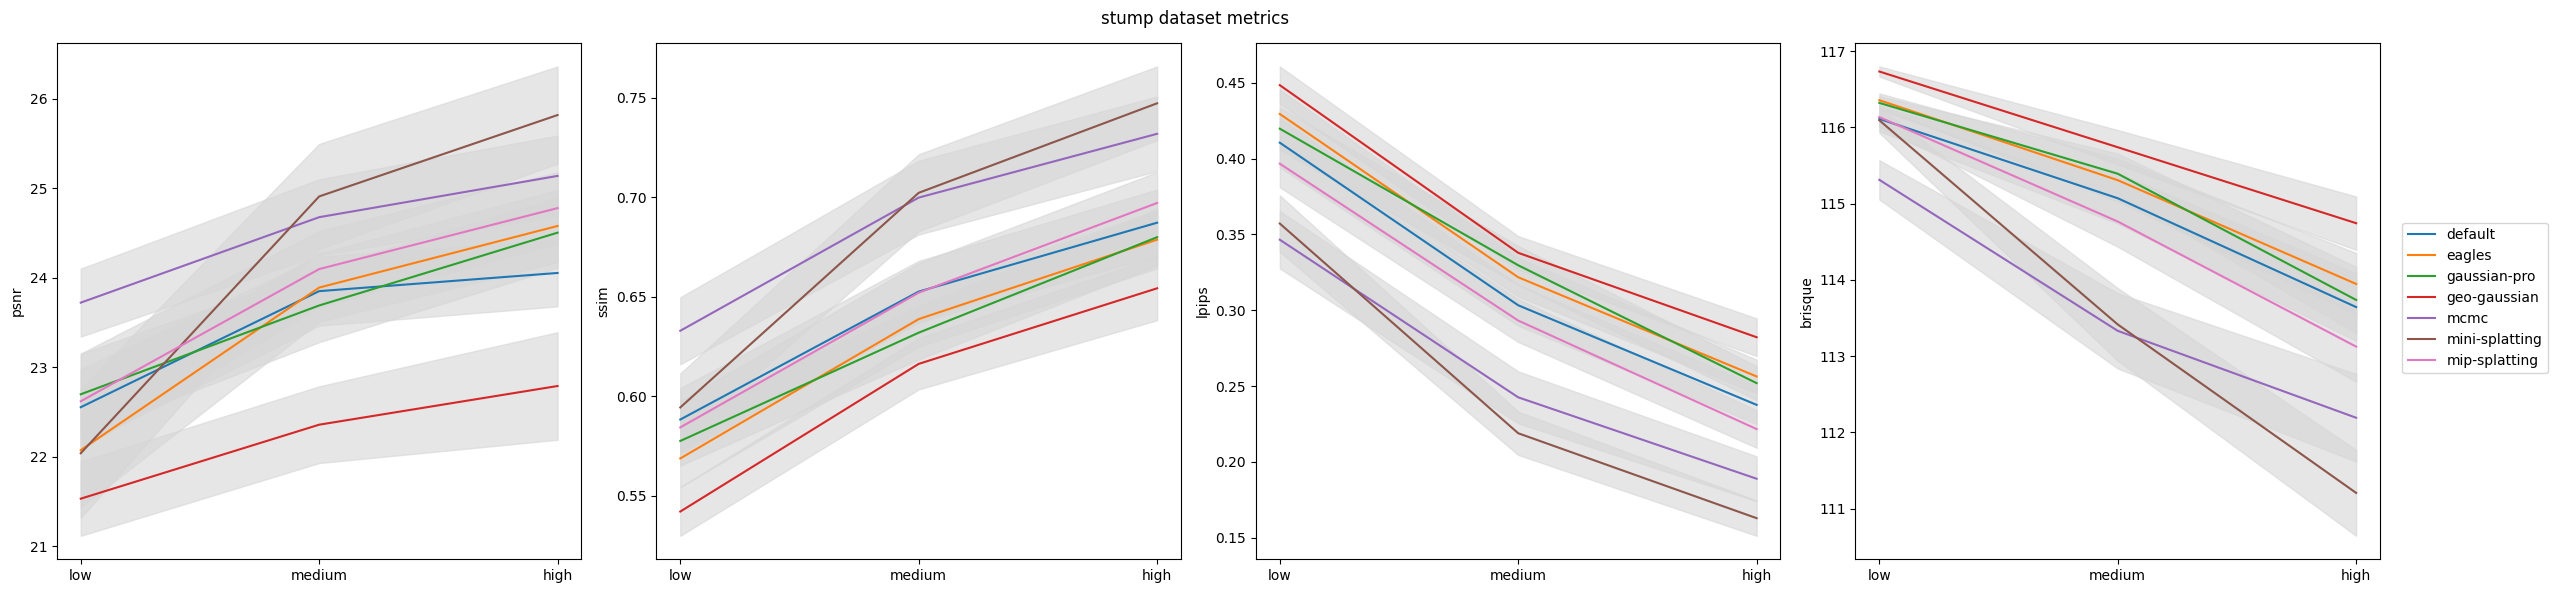

In [202]:
contrast_ranking_by_size("stump")

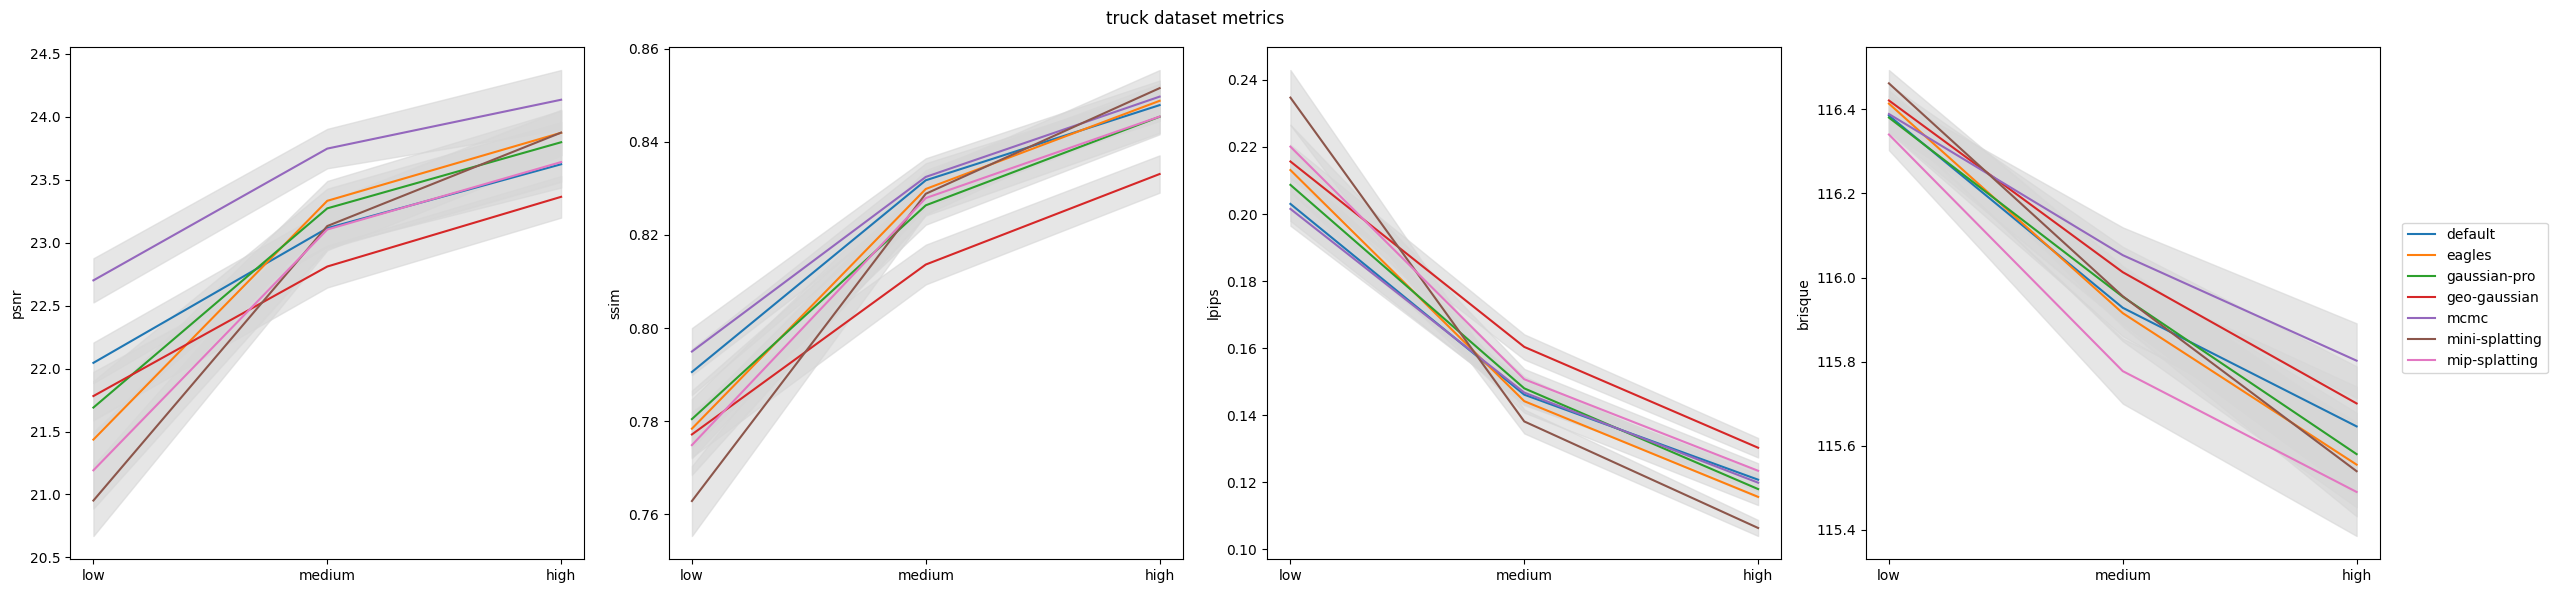

In [203]:
contrast_ranking_by_size("truck")

## Correlation Analysis

So given my JOD values, what kind of correlation could I even compute?

For each facet of my data I can create scatterplot where one observation is a method.

### Correlation analysis by facet

In [182]:
from typing import Dict
from matplotlib import pyplot as plt
from scipy.stats import pearsonr, norm, spearmanr
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


def compute_linear_rmse(x, y) -> float:
    X = x.values.reshape(-1, 1)  # Reshape for sklearn
    y = y.values

    linear_model = LinearRegression()
    linear_model.fit(X, y)
    y_pred_linear = linear_model.predict(X)
    rmse_linear = np.sqrt(mean_squared_error(y, y_pred_linear))
    return rmse_linear


def compute_nonlinear_rmse(x, y) -> float:
    X = x.values.reshape(-1, 1)  # Reshape for sklearn
    y = y.values

    # Nonlinear (Quadratic) Regression
    X_nonlinear = np.column_stack((X, X**2))  # Add x^2 term
    nonlinear_model = (
        LinearRegression()
    )  # Still use linear regression, but with transformed features
    nonlinear_model.fit(X_nonlinear, y)
    y_pred_nonlinear = nonlinear_model.predict(X_nonlinear)
    rmse_nonlinear = np.sqrt(mean_squared_error(y, y_pred_nonlinear))
    return rmse_nonlinear


def compute_spearman(x, y) -> float:
    corr, _ = spearmanr(x, y)
    return corr


def compute_pearsonr(x, y) -> float:
    corr, _ = pearsonr(x, y)
    return corr


def plot_quality_metric_against_jod_by_facet(quality_metric: str = "psnr") -> None:
    fig, axs = plt.subplots(3, 3)

    for i, dataset in enumerate(df_metrics["dataset"].unique()):
        for j, size in enumerate(["low", "medium", "high"]):
            single_facet_df = join_quality_metrics_by_facet(
                quality_metric, dataset, size
            )
            axs[i][j].scatter(single_facet_df["jod"], single_facet_df[quality_metric])

    fig.suptitle(quality_metric)
    plt.show()


def plot_quality_metric_against_jod(quality_metric: str = "psnr") -> None:
    df = join_quality_metrics(quality_metric)
    plt.scatter(df["jod"], df[quality_metric])

    plt.suptitle(quality_metric)
    plt.show()


def join_quality_metrics(quality_metric: str) -> pd.DataFrame:
    df_jod_agg = df_jod.melt(
        id_vars=["dataset", "size"],
        value_vars=[
            "default",
            "mcmc",
            "mini_splatting",
            "eagles",
            "mip_splatting",
            "gaussian_pro",
            "geo_gaussian",
        ],
    ).rename({"variable": "model", "value": "jod"}, axis=1)
    df_jod_agg["model"] = df_jod_agg["model"].apply(lambda x: x.replace("_", "-"))
    df_jod_agg = df_jod_agg.set_index(["model", "dataset", "size"])
    df_metrics_agg = df_metrics.groupby(["model", "dataset", "size"])[
        [quality_metric]
    ].mean()
    return df_jod_agg.join(df_metrics_agg)


def join_quality_metrics_by_facet(
    quality_metric: str, dataset: str, size: str
) -> pd.DataFrame:
    single_facet_df = (
        df_jod[(df_jod["dataset"] == dataset) & (df_jod["size"] == size)]
        .transpose()
        .iloc[3:]
        .rename(lambda x: "jod", axis=1)
    )
    metrics_df = aggregate_metrics_by_facet(df_metrics, quality_metric, dataset, size)
    single_facet_df = single_facet_df.join(metrics_df)
    return single_facet_df


def create_correlation_dataframe_by_facet(quality_metric: str = "psnr") -> pd.DataFrame:
    records = []
    for dataset in df_metrics["dataset"].unique():
        for size in ["low", "medium", "high"]:
            single_facet_df = join_quality_metrics_by_facet(
                quality_metric, dataset, size
            )
            records.append(
                create_record(quality_metric, single_facet_df, dataset, size)
            )
    return pd.DataFrame.from_records(records)


def create_record(
    quality_metric: str,
    df: pd.DataFrame,
    dataset: str = None,
    size: str = None,
) -> Dict:
    record = {
        "SROCC": compute_spearman(df["jod"], df[quality_metric]),
        "PLCC": compute_pearsonr(
            df["jod"].astype(np.float32),
            df[quality_metric].astype(np.float32),
        ),
        "RMSE_lin": compute_linear_rmse(
            df["jod"],
            df[quality_metric],
        ),
        "RMSE_cub": compute_nonlinear_rmse(
            df["jod"],
            df[quality_metric],
        ),
    }

    if dataset is not None:
        record["dataset"] = dataset
    if size is not None:
        record["size"] = size

    return record


def aggregate_metrics(quality_metric: str) -> pd.DataFrame:
    if quality_metric == "brisque":
        metric_single_facet = (
            df_metrics.melt(
                id_vars=["model", "dataset", "size", "view_idx"],
                value_vars=[
                    "brisque",
                    "brisque_0",
                    "brisque_1",
                    "brisque_2",
                    "brisque_3",
                    "brisque_4",
                ],
            )
            .groupby(["model", "dataset", "size"])["value"]
            .mean()
        )
    else:
        metric_single_facet = df_metrics.groupby(["model", "dataset", "size"])[
            quality_metric
        ].mean()
    metrics_df = pd.DataFrame.from_dict(
        {
            "technique": [
                technique.replace("-", "_")
                for technique, _, _ in metric_single_facet.index
            ],
            quality_metric: metric_single_facet.values,
        }
    ).set_index("technique")

    return metrics_df


def aggregate_metrics_by_facet(
    df: pd.DataFrame, quality_metric: str, dataset: str, size: str
) -> pd.DataFrame:
    if quality_metric == "brisque":
        metric_single_facet = (
            df[(df["dataset"] == dataset) & (df["size"] == size)]
            .melt(
                id_vars=["model", "dataset", "size", "view_idx"],
                value_vars=[
                    "brisque",
                    "brisque_0",
                    "brisque_1",
                    "brisque_2",
                    "brisque_3",
                    "brisque_4",
                ],
            )
            .groupby(["model", "dataset", "size"])["value"]
            .mean()
        )
    else:
        metric_single_facet = (
            df[(df["dataset"] == dataset) & (df["size"] == size)]
            .groupby(["model", "dataset", "size"])[quality_metric]
            .mean()
        )
    metrics_df = pd.DataFrame.from_dict(
        {
            "technique": [
                technique.replace("-", "_")
                for technique, _, _ in metric_single_facet.index
            ],
            quality_metric: metric_single_facet.values,
        }
    ).set_index("technique")

    return metrics_df

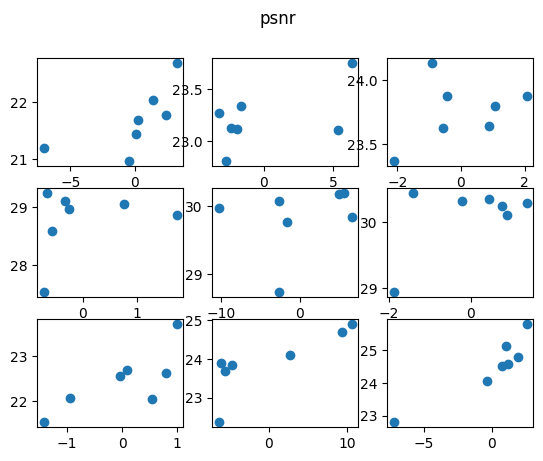

In [183]:
plot_quality_metric_against_jod_by_facet()
df_psnr = create_correlation_dataframe_by_facet()

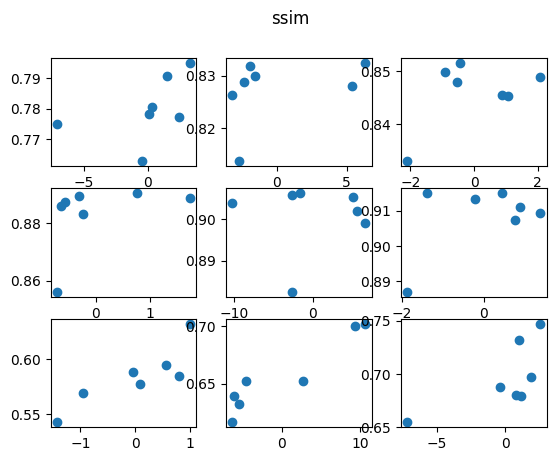

In [184]:
plot_quality_metric_against_jod_by_facet("ssim")
df_ssim = create_correlation_dataframe_by_facet("ssim")

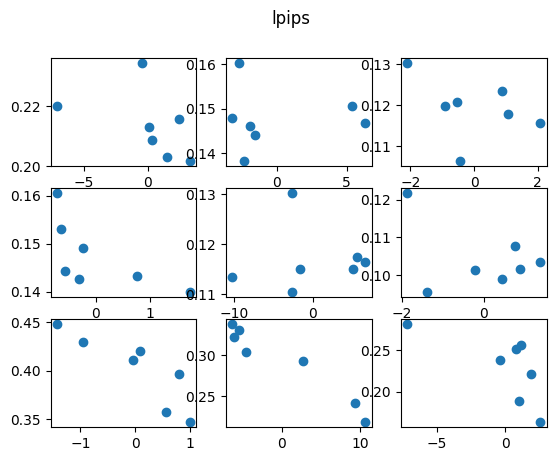

In [185]:
plot_quality_metric_against_jod_by_facet("lpips")
df_lpips = create_correlation_dataframe_by_facet("lpips")

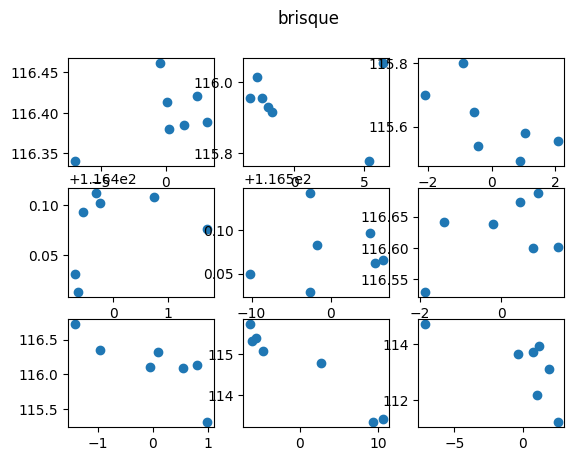

In [186]:
plot_quality_metric_against_jod_by_facet("brisque")
df_brisque = create_correlation_dataframe_by_facet("brisque")

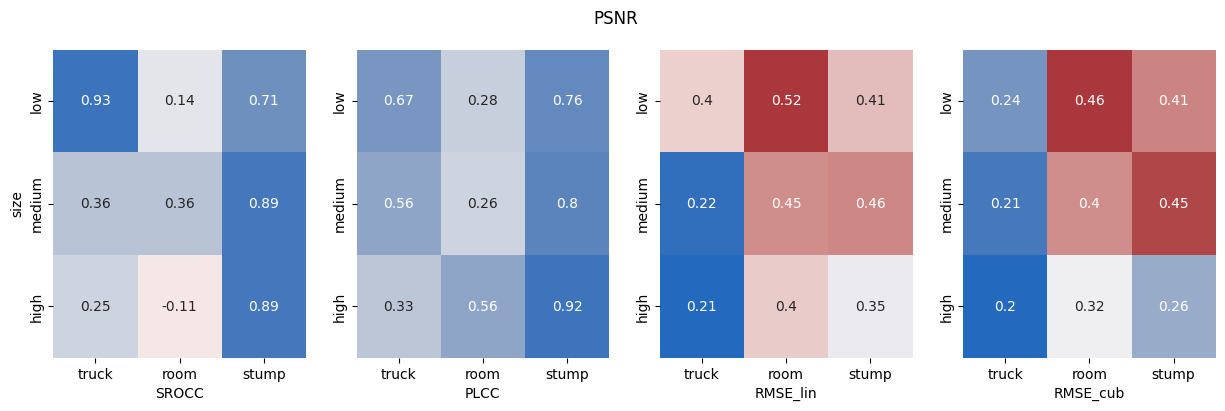

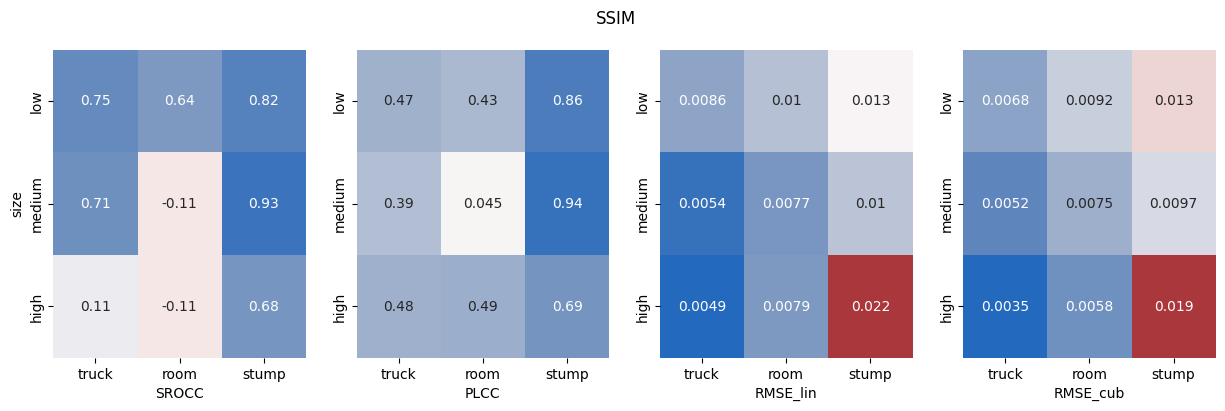

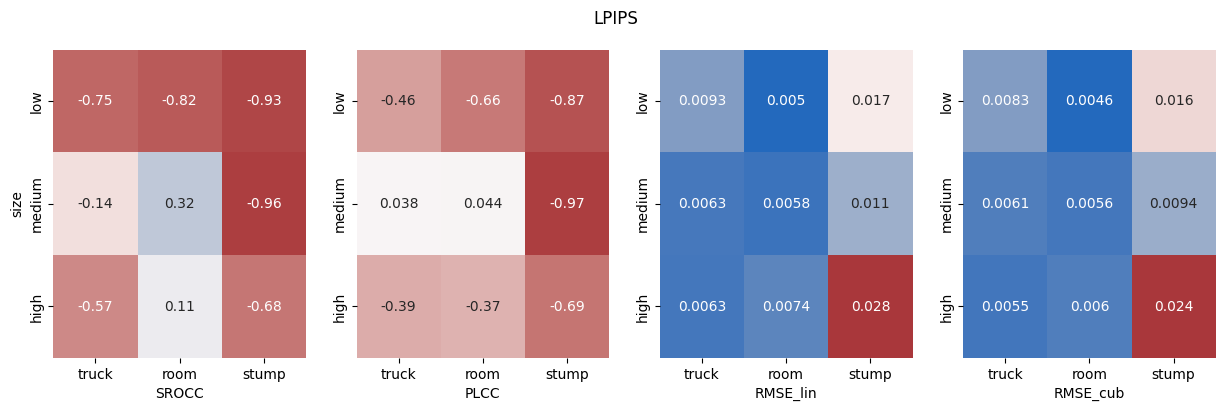

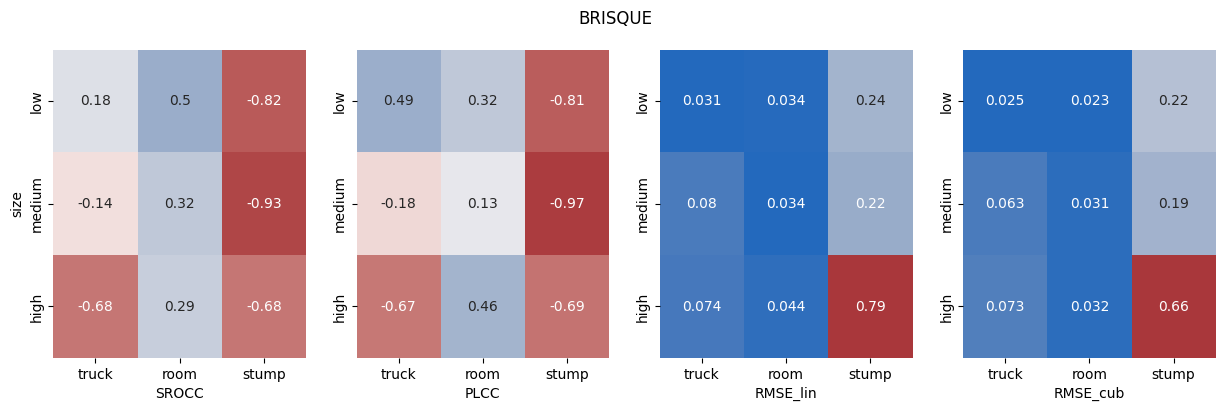

In [187]:
import seaborn as sns


def plot_heatmap_for_metrics(dataframe: pd.DataFrame, title: str):
    metrics = ["SROCC", "PLCC", "RMSE_lin", "RMSE_cub"]

    fig, axs = plt.subplots(1, len(metrics), figsize=(15, 4))

    for i, metric in enumerate(metrics):
        df_pivot = dataframe[[metric, "size", "dataset"]]
        df_pivot = pd.pivot(
            df_pivot, columns=["dataset"], index=["size"], values=[metric]
        )
        df_pivot.columns = df_pivot.columns.map(lambda x: x[1])
        df_pivot.index = pd.CategoricalIndex(
            df_pivot.index, categories=["low", "medium", "high"], ordered=True
        )
        df_pivot.sort_index(inplace=True)
        cmap = sns.color_palette("vlag", as_cmap=True).reversed()
        if "RMSE" in metric:
           cmap = cmap.reversed()
        sns.heatmap(
            df_pivot[["truck", "room", "stump"]],
            annot=True,
            ax=axs[i],
            cbar=False,
            cmap=cmap,
            vmin=None if "RMSE" in metric else -1,
            vmax=None if "RMSE" in metric else 1,
        )
        axs[i].set_xlabel(metric)
        if i > 0:
            axs[i].set_ylabel("")

    fig.suptitle(title)
    plt.show()


plot_heatmap_for_metrics(df_psnr, "PSNR")
plot_heatmap_for_metrics(df_ssim, "SSIM")
plot_heatmap_for_metrics(df_lpips, "LPIPS")
plot_heatmap_for_metrics(df_brisque, "BRISQUE")

### Correlation analysis without facets

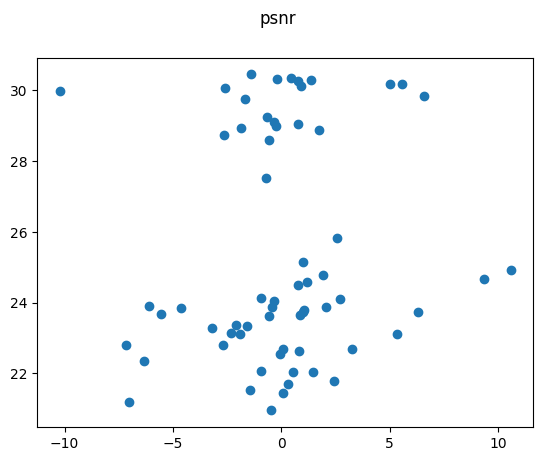

In [188]:
plot_quality_metric_against_jod("psnr")

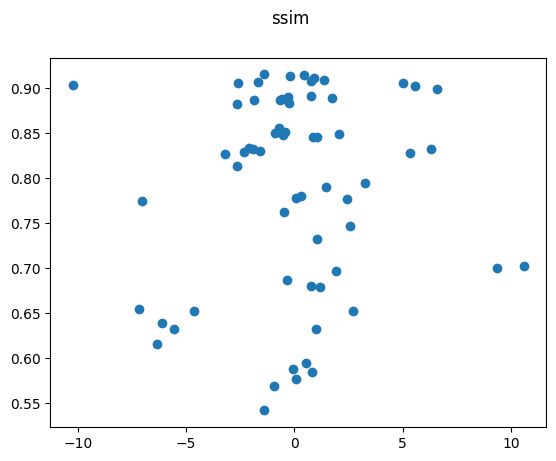

In [189]:
plot_quality_metric_against_jod("ssim")

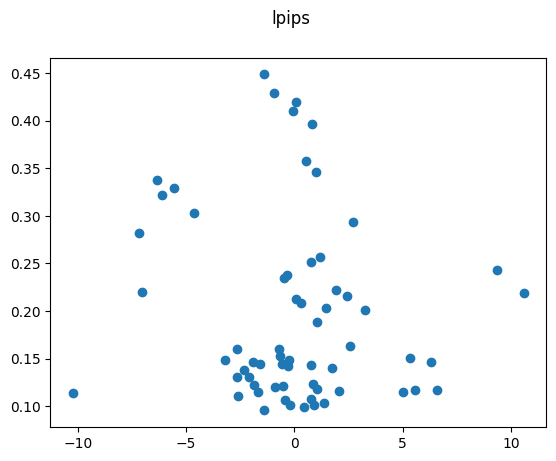

In [190]:
plot_quality_metric_against_jod("lpips")

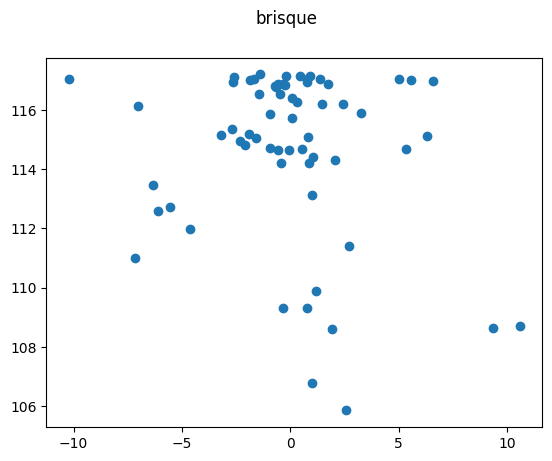

In [191]:
plot_quality_metric_against_jod("brisque")

### K-Fold Correlation Analysis

In [218]:
jod_cv_10 = pd.read_excel("data/jod_k_fold_10.xlsx")

In [248]:
from sklearn.model_selection import KFold


def compute_cv_correlation_analysis(jod_cv_df: pd.DataFrame) -> pd.DataFrame:
    K = jod_cv_df["fold_idx"].max() + 1

    records = []

    for dataset in ["room", "stump", "truck"]:
        for size in ["low", "medium", "high"]:
            for quality_metric in ["psnr", "ssim", "lpips", "brisque"]:
                kf = KFold(n_splits=K, shuffle=True, random_state=42)

                facet_metrics = df_metrics[
                    (df_metrics["size"] == size) & (df_metrics["dataset"] == dataset)
                ]
                for fold_idx, (train_idx, test_idx) in enumerate(kf.split(facet_metrics)):
                    fold_metrics = facet_metrics.iloc[train_idx]
                    fold_jod = jod_cv_df[
                        (jod_cv_df["dataset"] == dataset)
                        & (jod_cv_df["size"] == size)
                        & (jod_cv_df["fold_idx"] == fold_idx)
                    ]
                    df_agg_metrics = aggregate_metrics_by_facet(
                        facet_metrics, quality_metric, dataset, size
                    )
                    df_agg_metrics = df_agg_metrics.join(
                        fold_jod.transpose().iloc[4:].rename(lambda x: "jod", axis=1)
                    )
                    records.append(
                        {
                            "metric": quality_metric,
                            "dataset": dataset,
                            "size": size,
                            "fold_idx": fold_idx,
                            "SROCC": compute_spearman(
                                df_agg_metrics["jod"], df_agg_metrics[quality_metric]
                            ),
                            "PLCC": compute_pearsonr(
                                df_agg_metrics["jod"].astype(np.float32),
                                df_agg_metrics[quality_metric].astype(np.float32),
                            ),
                        }
                    )
    return pd.DataFrame.from_records(records)


df_cv_10 = compute_cv_correlation_analysis(jod_cv_10)

In [287]:
import seaborn as sns


def plot_cv_results(
    df_cv: pd.DataFrame,
    corr_measure: str = "PLCC",
    metric: str = "psnr",
    ax: plt.Axes = None,
) -> None:
    K = df_cv["fold_idx"].max() + 1
    df_cv_plot = df_cv.copy()[df_cv["metric"] == metric]
    df_cv_plot["facet"] = df_cv_plot[["dataset", "size"]].apply(
        lambda row: f"{row.iloc[0]}-{row.iloc[1]}", axis=1
    )

    if ax is None:
        plt.figure(figsize=(7, 5))
    sns.violinplot(df_cv_plot, x="facet", y=corr_measure, hue="dataset", ax=ax)
    if ax is None:
        plt.suptitle(
            f"Correlation ({corr_measure}) {K}-Fold CV - JOD vs. {metric.upper()}"
        )
        plt.xticks(rotation=90)
        plt.show()
    else:
        ax.set_title(
            f"Correlation ({corr_measure}) {K}-Fold CV - JOD vs. {metric.upper()}"
        )
        ax.set_xticks(ax.get_xticks(), ["low", "medium", "high"] * 3)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.set_xlabel("")

### 10 Fold CV

In [288]:
def plot_cv_results_full(df_cv: pd.DataFrame) -> None:
    fig, axs = plt.subplots(4, 2, figsize=(14, 20))
    for idx_c, corr_measure in enumerate(["PLCC", "SROCC"]):
        for idx_m, metric in enumerate(["ssim", "psnr", "lpips", "brisque"]):
            plot_cv_results(df_cv, corr_measure, metric, ax=axs[idx_m][idx_c])
    plt.tight_layout()
    plt.show()

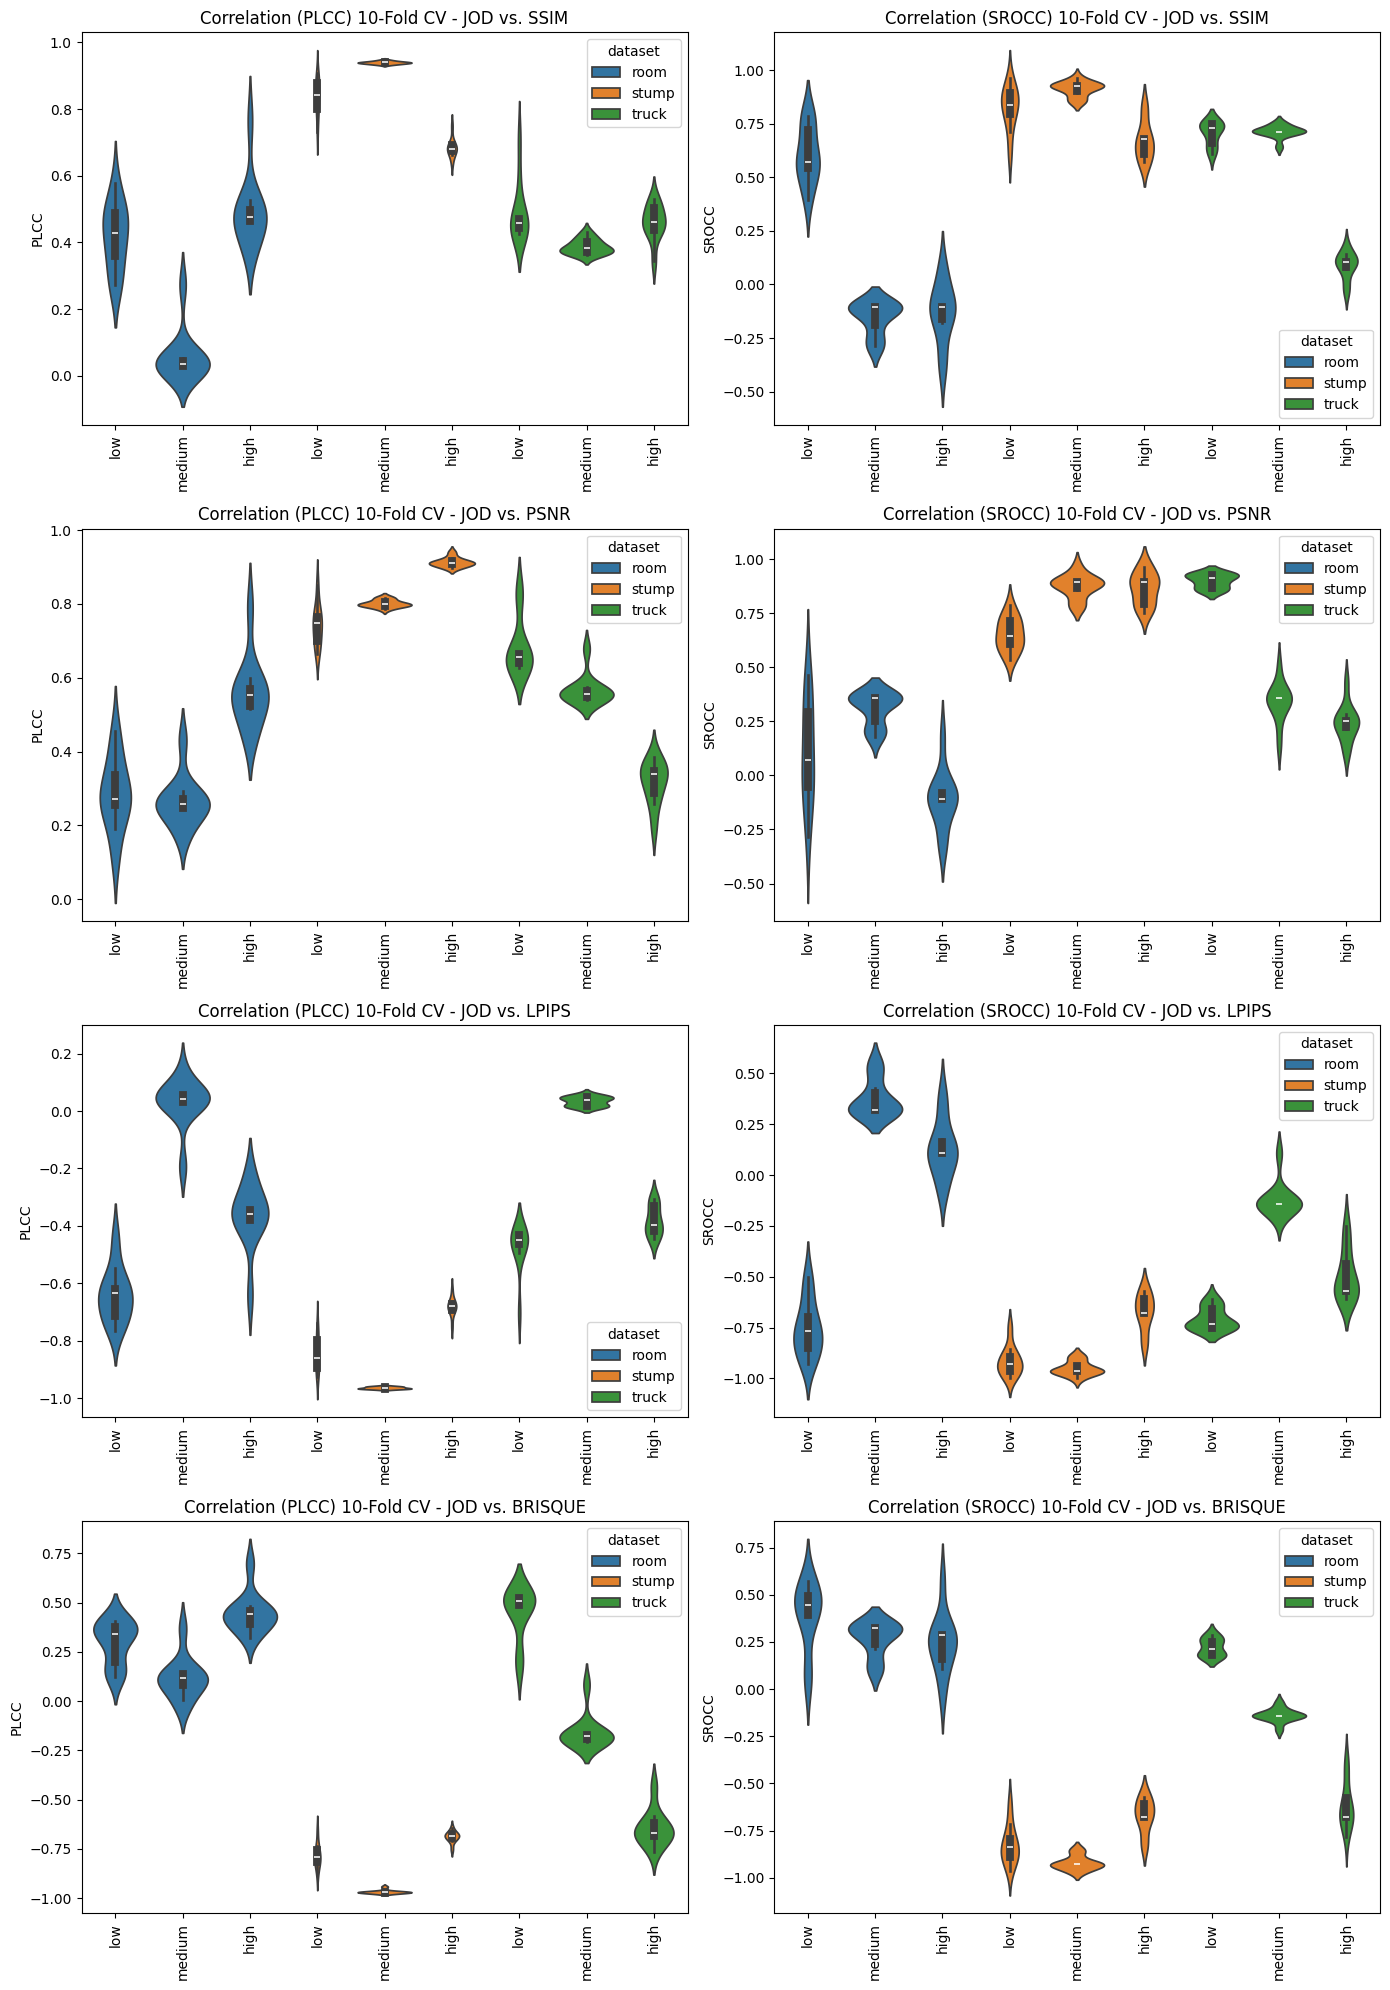

In [289]:
plot_cv_results_full(df_cv_10)

### 20 Fold CV

In [290]:
jod_cv_20 = pd.read_excel("data/jod_k_fold_20.xlsx")
df_cv_20 = compute_cv_correlation_analysis(jod_cv_20)

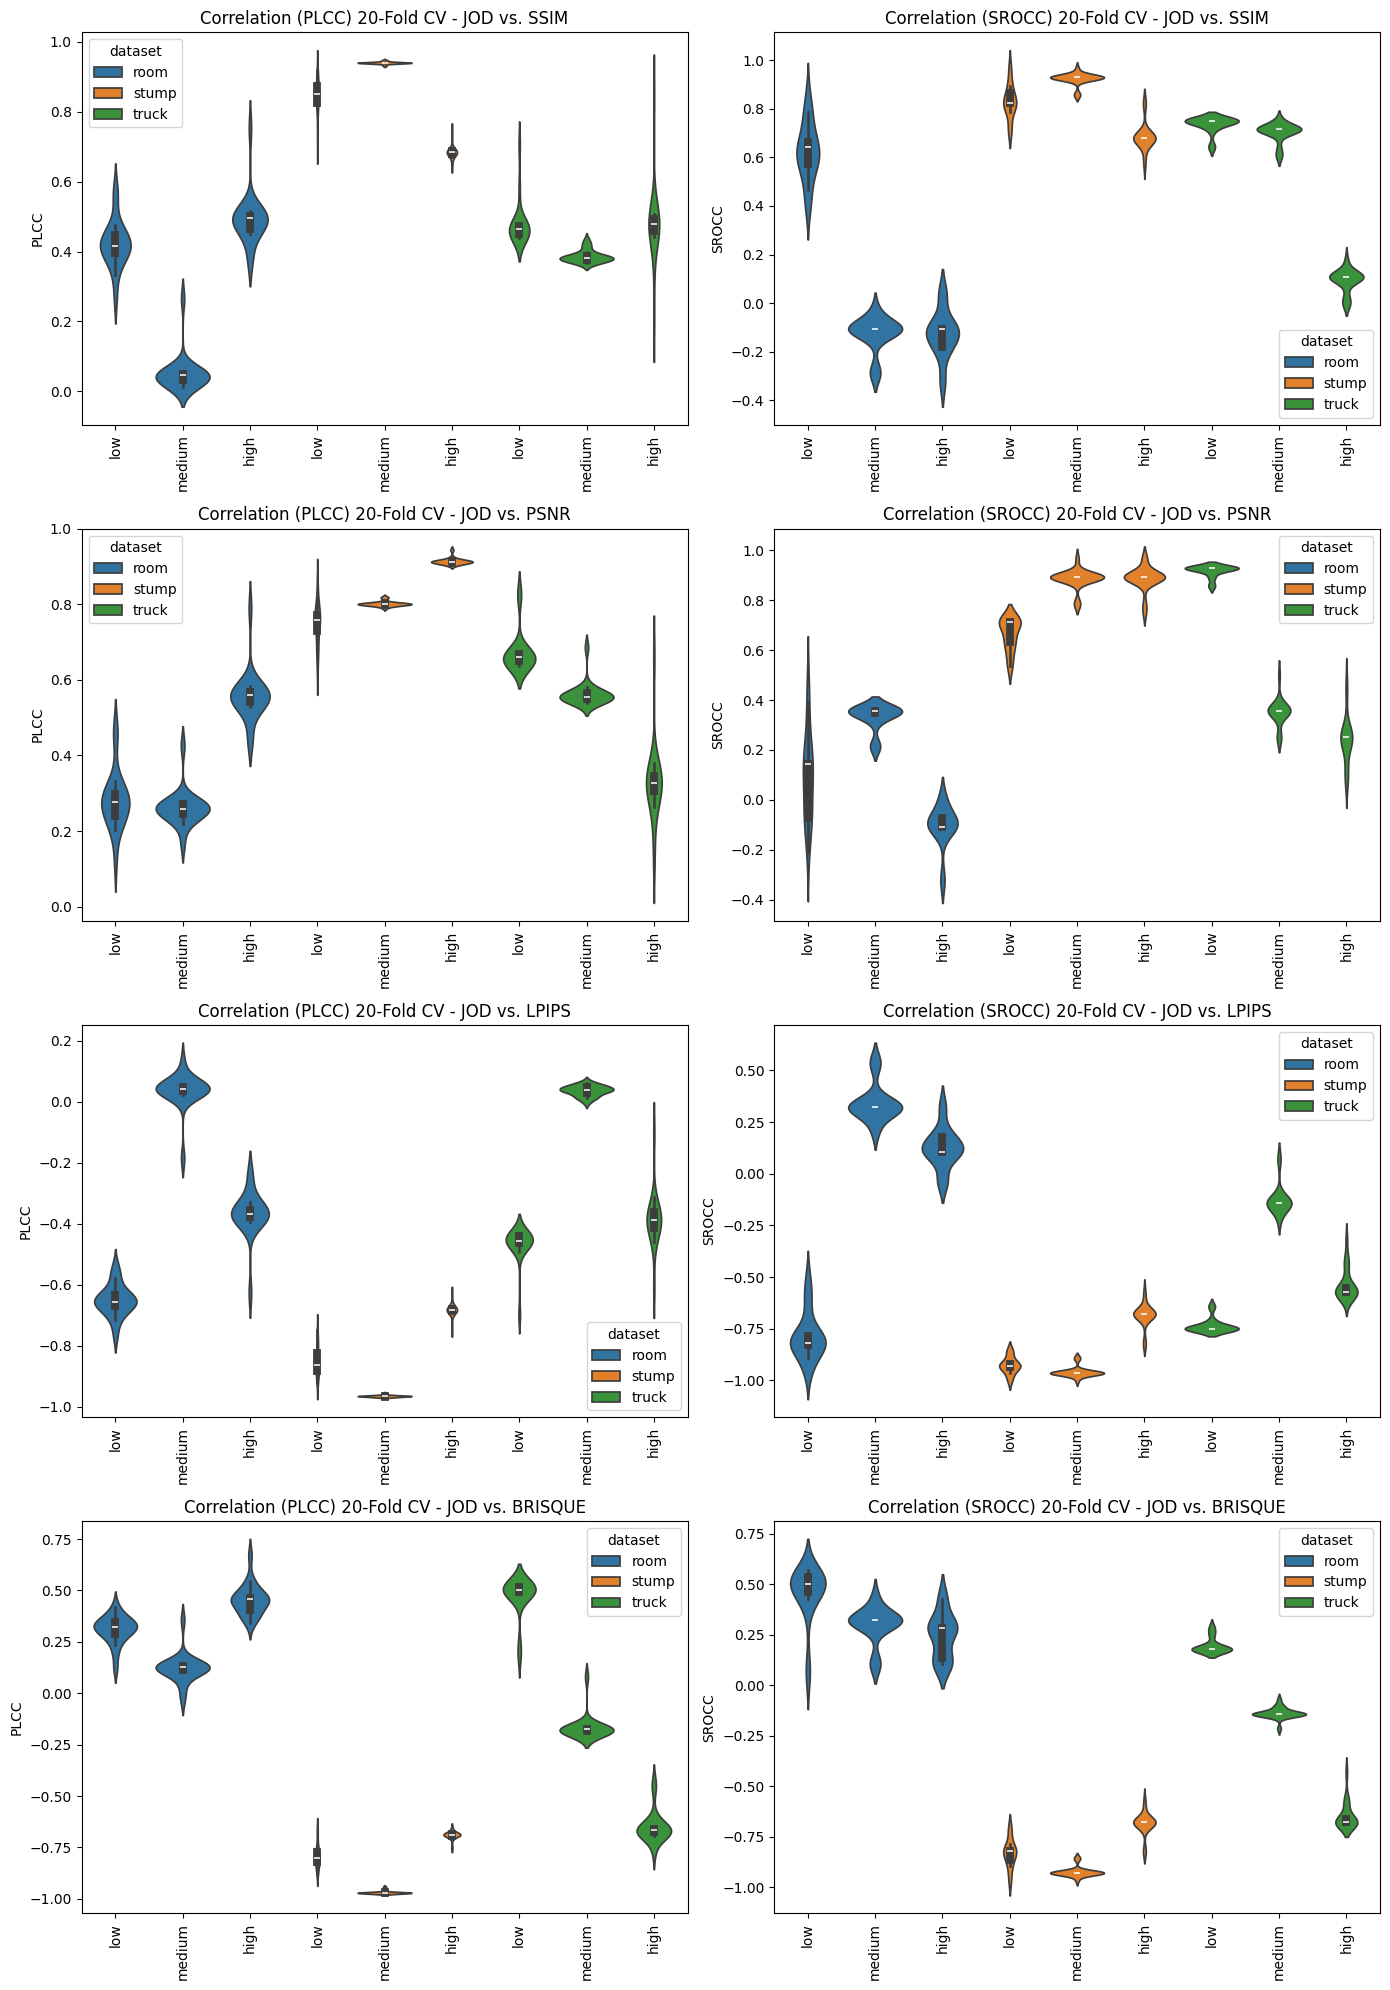

In [291]:
plot_cv_results_full(df_cv_20)

### How does the JOD variability look when displaying it as a violin plot?

In [331]:
jod_cv_20

,Unnamed: 0,size,dataset,fold_idx,default,mcmc,mini_splatting,eagles,mip_splatting,gaussian_pro,geo_gaussian
0,0,low,room,0,1.889599,-0.641652,-0.747568,-0.384492,1.225611,-0.598738,-0.742762
1,1,low,room,1,6.410905,-0.724706,-1.700299,-1.280626,-0.279626,-1.016188,-1.409475
2,2,low,room,2,1.692514,-0.041335,-0.633308,-0.540559,0.658998,-0.445071,-0.691242
3,3,low,room,3,1.681915,-0.237478,-0.644640,-0.559102,0.751033,-0.312601,-0.679129
4,4,low,room,4,1.652473,-0.229456,-0.643158,-0.547514,0.670736,-0.313977,-0.589104
...,...,...,...,...,...,...,...,...,...,...,...
175,175,high,truck,15,-0.536126,-0.902467,-0.505849,2.041196,0.843753,1.029916,-1.970423
176,176,high,truck,16,-0.536126,-0.902467,-0.505849,2.041196,0.843753,1.029916,-1.970423
177,177,high,truck,17,-0.527973,-0.672681,-0.620896,2.020922,0.825211,1.014218,-2.038803
178,178,high,truck,18,-0.679229,-0.895150,-0.426064,2.047629,0.868893,1.044147,-1.960229


([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'room-low'),
  Text(1, 0, 'room-medium'),
  Text(2, 0, 'room-high'),
  Text(3, 0, 'stump-low'),
  Text(4, 0, 'stump-medium'),
  Text(5, 0, 'stump-high'),
  Text(6, 0, 'truck-low'),
  Text(7, 0, 'truck-medium'),
  Text(8, 0, 'truck-high')])

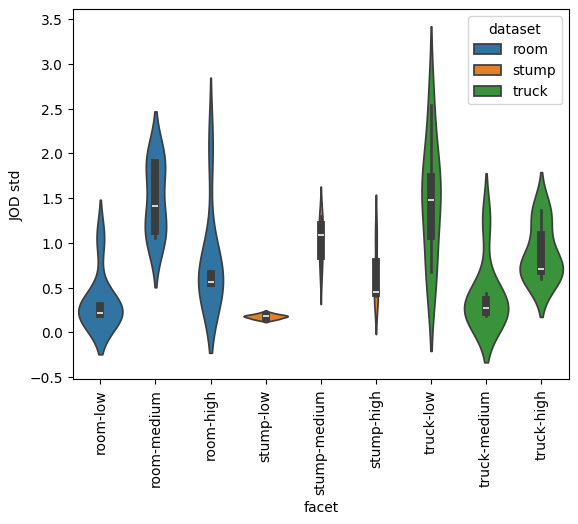

In [341]:
jod_cv_20_facet = jod_cv_20.copy()
jod_cv_20_facet["facet"] = jod_cv_20_facet[["dataset", "size"]].apply(
    lambda row: f"{row.iloc[0]}-{row.iloc[1]}", axis=1
)
jod_cv_20_facet = (
    (jod_cv_20_facet.iloc[:, 4:].groupby(["facet"]).std())
    .reset_index()
    .melt(id_vars="facet")
    .rename({"value": "JOD std"}, axis=1)
)
jod_cv_20_facet
jod_cv_20_facet["dataset"] = jod_cv_20_facet["facet"].apply(lambda x: x.split("-")[0])
jod_cv_20_facet["size"] = jod_cv_20_facet["facet"].apply(lambda x: x.split("-")[1])


def get_key(x):
    idx = {"low": 0, "medium": 1, "high": 2}
    return f"{x.split('-')[0]}-{idx[x.split('-')[1]]}"


jod_cv_20_facet = jod_cv_20_facet.sort_values("facet", key=np.vectorize(get_key))

sns.violinplot(jod_cv_20_facet, x="facet", y="JOD std", hue="dataset")
plt.xticks(rotation=90)

/tmp/ipykernel_13731/2623664365.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lambda x: f"{x[0]}-{x[1]}", axis=1


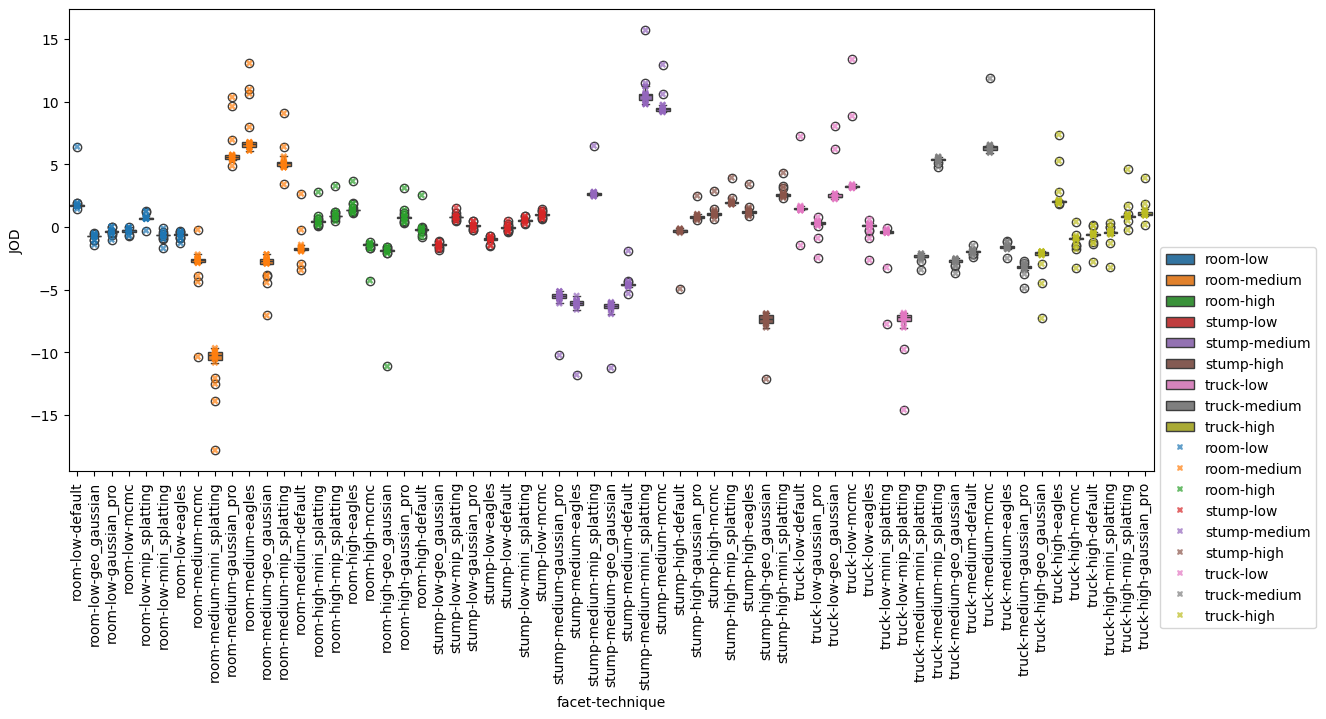

In [381]:
jod_cv_20_facet = jod_cv_20.copy()
jod_cv_20_facet["facet"] = jod_cv_20_facet[["dataset", "size"]].apply(
    lambda row: f"{row.iloc[0]}-{row.iloc[1]}", axis=1
)
jod_cv_20_facet = (
    (jod_cv_20_facet.iloc[:, 4:])
    .melt(id_vars="facet")
    .rename({"value": "JOD", "variable": "technique"}, axis=1)
)
jod_cv_20_facet["dataset"] = jod_cv_20_facet["facet"].apply(lambda x: x.split("-")[0])
jod_cv_20_facet["size"] = jod_cv_20_facet["facet"].apply(lambda x: x.split("-")[1])
jod_cv_20_facet["facet-technique"] = jod_cv_20_facet[["facet", "technique"]].apply(
    lambda x: f"{x[0]}-{x[1]}", axis=1
)
jod_cv_20_facet


def get_key(x):
    idx = {"low": 0, "medium": 1, "high": 2}
    return f"{x.split('-')[0]}-{idx[x.split('-')[1]]}"


jod_cv_20_facet = jod_cv_20_facet.sort_values("facet", key=np.vectorize(get_key))

plt.figure(figsize=(14, 6))
ax = sns.boxplot(jod_cv_20_facet, x="facet-technique", y="JOD", hue="facet")
sns.stripplot(
    jod_cv_20_facet,
    x="facet-technique",
    y="JOD",
    hue="facet",
    marker="X",
    jitter=False,
    alpha=0.7,
)
plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1.0, 0.5))
plt.show()

In [ ]:
psnr_single_facet = df_metrics[(df_metrics["dataset"] == "room") & (df_metrics["size"] == "low")].groupby(["model", "dataset", "size"])["psnr"].median()

In [ ]:
psnr_single_facet

model           dataset  size
default         room     low     28.898587
eagles          room     low     29.261131
gaussian-pro    room     low     29.310398
geo-gaussian    room     low     28.178413
mcmc            room     low     29.038901
mini-splatting  room     low     29.608626
mip-splatting   room     low     28.971822
Name: psnr, dtype: float64

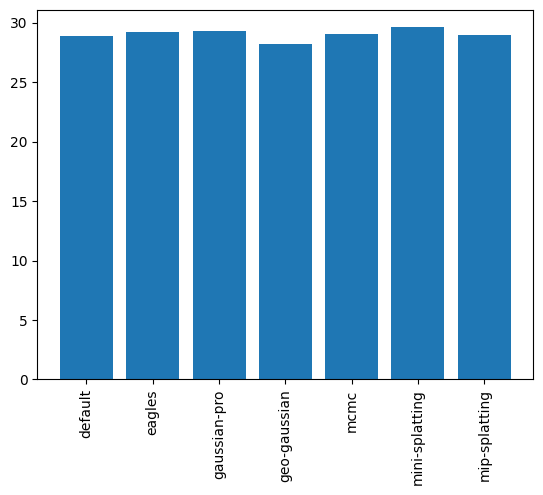

In [ ]:
plt.bar([technique for technique, _ , _ in psnr_single_facet.index], psnr_single_facet.values)
plt.xticks(rotation=90)
plt.show()